In [627]:
import geopandas as gpd
import pandas as pd
import h3
from shapely.geometry import Polygon

In [628]:
import os
from dotenv import load_dotenv

load_dotenv()
db_url = os.getenv("DB_URL")

In [629]:

from sqlalchemy import create_engine 
engine = create_engine(db_url)
ilce_gdf = gpd.read_postgis("SELECT * FROM ilce_temel_kpi;", engine, geom_col="ilce_geom").to_crs(epsg=4326)
ilce_gdf.head()

,ilce,musteri_sayisi,toplam_siparis,ort_kar,toplam_kar,ort_revenue,toplam_revenue,ort_delivery,ilce_geom
0,Nilüfer,11239,17686,132.42,2341940.31,360.89,6382780.11,16.89,"MULTIPOLYGON (((28.74359 40.29972, 28.7422 40...."
1,Osmangazi,4541,6778,123.44,836649.23,352.25,2387538.17,18.53,"MULTIPOLYGON (((29.11404 40.34778, 29.11244 40..."
2,Yıldırım,1348,1758,118.23,207850.72,365.04,641738.92,34.21,"MULTIPOLYGON (((29.14374 40.2515, 29.14335 40...."


In [630]:
siparis = gpd.read_postgis("SELECT * FROM siparis;", engine, geom_col = "geometry").to_crs(epsg=4326)
siparis.head()

,fid,order_id,latitude,longitude,basket_value,delivery duration,profit,revenue,client_id,geometry
0,0,81512055,40.186535,29.095203,637.6238,22.016667,-149.4062,344.3338,client_79144640,POINT (29.0952 40.18653)
1,1,22267042,40.234744,28.836608,373.0099,9.966667,-17.7624,200.3235,client_24816618,POINT (28.83661 40.23474)
2,2,88017435,40.217676,28.903509,837.5562,7.783333,-30.7442,432.8338,client_16797643,POINT (28.90351 40.21768)
3,3,72989589,40.218052,28.945997,819.1121,15.466667,-86.2728,435.2127,client_78716540,POINT (28.946 40.21805)
4,4,42175004,40.194676,28.988171,187.6337,27.016667,88.7932,221.4132,client_84428508,POINT (28.98817 40.19468)


In [631]:
ilce_geom = ilce_gdf.union_all()

In [632]:
#ilce geometrilerinin koordinatlarını çekelim
coords = list(ilce_geom.exterior.coords)
latlngs = [(y, x) for x, y in coords]  


hex_ids = h3.geo_to_cells(ilce_geom.__geo_interface__, res=8)

#ilce geometrilerini 8 çözünürlüklü h3 hücreleriyle dolduralım.
def h3_to_polygon(hid):
    boundary = h3.cell_to_boundary(hid)
    return Polygon([(lng, lat) for lat, lng in boundary])

grid_gdf = gpd.GeoDataFrame({
    "h3_index": list(hex_ids),
    "geometry": [h3_to_polygon(hid) for hid in hex_ids]
}, crs="EPSG:4326")

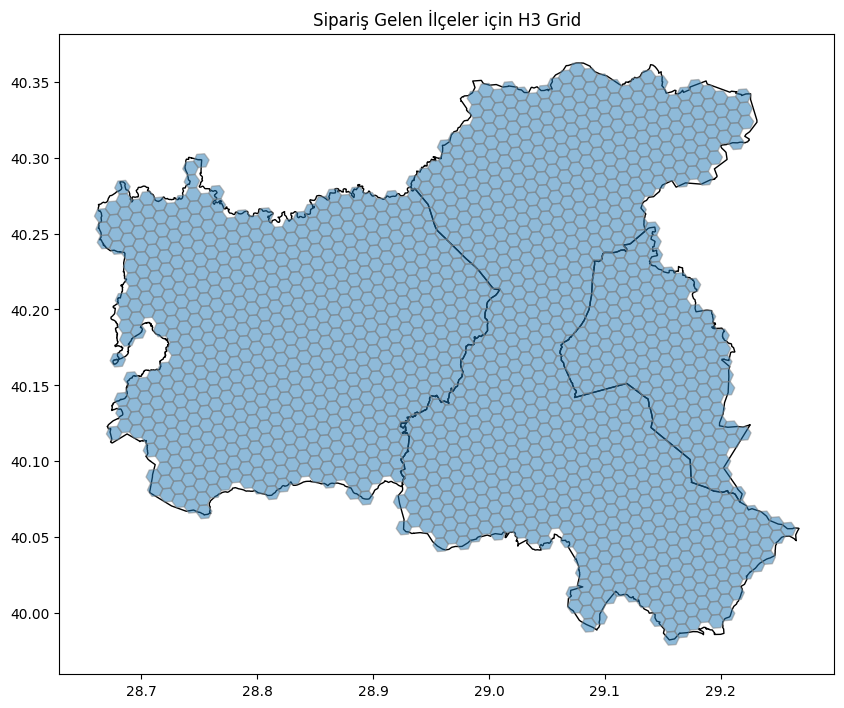

In [633]:
#kontrol
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 10))
ilce_gdf.plot(ax=ax, color='none', edgecolor='black')
grid_gdf.plot(ax=ax, alpha=0.5, edgecolor='gray')
plt.title("Sipariş Gelen İlçeler için H3 Grid")
plt.show()

In [634]:
#h3 hücreleri bazında değerleri hesaplayalım.
siparis["h3_index"] = siparis.apply(
    lambda row: h3.latlng_to_cell(row["latitude"], row["longitude"], 8), axis=1
)

h3_stats = siparis.groupby("h3_index").agg(
    sip_adedi_g=("order_id", "count"),
    mus_sayisi_g=("client_id", "count"),
    ort_sure_g=("delivery duration", "mean"),
    top_sure_g=("delivery duration", "sum"),
    ort_sepet_g=("basket_value", "mean"),
    top_kar_g=("profit", "sum")
).reset_index()


grid_gdf = grid_gdf.merge(h3_stats, on="h3_index", how="left")

# NaN olan hücrelere 0 ata
for col in ["sip_adedi_g","mus_sayisi_g","ort_sure_g", "top_sure_g","ort_sepet_g", "top_kar_g"]:
    grid_gdf[col] = grid_gdf[col].fillna(0)

grid_gdf.head()

,h3_index,geometry,sip_adedi_g,mus_sayisi_g,ort_sure_g,top_sure_g,ort_sepet_g,top_kar_g
0,882d34968dfffff,"POLYGON ((29.00065 40.29665, 28.99792 40.29212...",0.0,0.0,0.0,0.0,0.0,0.0
1,881ec96d07fffff,"POLYGON ((29.07695 40.32765, 29.07422 40.32311...",0.0,0.0,0.0,0.0,0.0,0.0
2,882d3480c5fffff,"POLYGON ((29.14533 40.1223, 29.1426 40.11776, ...",0.0,0.0,0.0,0.0,0.0,0.0
3,882d3490d1fffff,"POLYGON ((28.94821 40.16664, 28.94548 40.1621,...",0.0,0.0,0.0,0.0,0.0,0.0
4,882d348159fffff,"POLYGON ((29.09386 40.05787, 29.09114 40.05333...",0.0,0.0,0.0,0.0,0.0,0.0


In [635]:
depo_gdf = gpd.read_postgis("SELECT * FROM warehouse;", engine, geom_col="geometry").to_crs(epsg=4326)
depo_gdf.head()

,fid,city_name,warehouse,lon,lat,geometry
0,0,Bursa,wh_1,28.913683,40.223470,POINT (28.91368 40.22347)
1,1,Bursa,wh_2,29.009756,40.199254,POINT (29.00976 40.19925)
2,2,Bursa,wh_3,28.969918,40.220589,POINT (28.96992 40.22059)
3,3,Bursa,wh_4,29.057349,40.187396,POINT (29.05735 40.1874)
4,4,Bursa,wh_5,28.953623,40.262806,POINT (28.95362 40.26281)


In [636]:
mahalle_gdf = gpd.read_postgis("SELECT * FROM mahalle_joined;", engine, geom_col = "geometry").to_crs(epsg=4326)
mahalle_gdf.head()

,yil,il,ilce,mahalle,mahalle_kodu,uzunluk,alan,nufus,nufus_yogunlugu,geometry,mahalle_id,agirlikli_ses_skoru
0,2024.0,Bursa,Nilüfer,29 Ekim,140336,6029.236564,1.373578e+06,14587.0,10619.708883,"MULTIPOLYGON (((28.91449 40.21585, 28.91459 40...",4,4.31
1,2024.0,Bursa,Karacabey,Abdullahpaşa,19962,1088.899955,4.963712e+04,1157.0,23309.167507,"MULTIPOLYGON (((28.36141 40.21811, 28.3616 40....",10,1.62
2,2024.0,Bursa,Gürsu,Adaköy,11366,11378.931598,7.029472e+06,1305.0,185.646957,"MULTIPOLYGON (((29.22348 40.24378, 29.23803 40...",11,1.59
3,2024.0,Bursa,Nilüfer,Ahmet Yesevi,11123,4166.951901,1.020135e+06,9021.0,8842.945783,"MULTIPOLYGON (((28.94037 40.27372, 28.94063 40...",17,2.67
4,2024.0,Bursa,İnegöl,Akbaşlar,183709,18217.046886,5.585251e+06,170.0,30.437307,"MULTIPOLYGON (((29.5839 40.10968, 29.58397 40....",23,0.07


In [637]:
mahalle_kpi  = gpd.read_postgis("SELECT * FROM mahalle_talep_penetrasyon_orani;", engine, geom_col = "geometry").to_crs(epsg=4326)

mahalle_kpi.head()

,mahalle_id,mahalle,ilce,toplam_siparis,musteri_sayisi,nufus,talep_yogunlugu,penetrasyon_orani,geometry,siparis_yog_km2,musteri_yog_km2
0,313,FETHİYEOSB,Nilüfer,14,12,NaN,NaN,NaN,"MULTIPOLYGON (((28.96566 40.2293, 28.96415 40....",6.530058,6.530058
1,464,IŞIKTEPEOSB,Nilüfer,210,123,NaN,NaN,NaN,"MULTIPOLYGON (((28.96188 40.22913, 28.96415 40...",80.575187,80.575187
2,246,Dumlupınar,Nilüfer,2483,1634,28594.0,0.0868,0.0571,"MULTIPOLYGON (((28.83069 40.23083, 28.83073 40...",753.559255,753.559255
3,50,Alacamescit,Osmangazi,22,15,290.0,0.0759,0.0517,"MULTIPOLYGON (((29.06738 40.18107, 29.06728 40...",350.269198,350.269198
4,363,Görükle,Nilüfer,2317,1607,32489.0,0.0713,0.0495,"MULTIPOLYGON (((28.85719 40.268, 28.85804 40.2...",110.175443,110.175443


In [638]:
mahalle_temel_kpi = gpd.read_postgis("SELECT * FROM temel_kpi_mahalle;", engine, geom_col = "geometry").to_crs(epsg=4326)
mahalle_temel_kpi.head()

,mahalle_id,il,ilce,mahalle,siparis_sayisi,ort_teslim_suresi,toplam_kar,ort_kar,ort_sepet_tutari,ort_revenue,toplam_revenue,nufus,agirlikli_ses_skoru,geometry
0,246,Bursa,Nilüfer,Dumlupınar,2483,16.93,294967.19,118.79,354.43,328.12,814719.35,28594.0,8.45,"MULTIPOLYGON (((28.83069 40.23083, 28.83073 40..."
1,363,Bursa,Nilüfer,Görükle,2317,20.78,258184.85,111.43,338.57,314.46,728610.82,32489.0,9.60,"MULTIPOLYGON (((28.85719 40.268, 28.85804 40.2..."
2,3,Bursa,Nilüfer,23 Nisan,956,16.07,136702.99,142.99,424.18,387.91,370842.52,21042.0,6.22,"MULTIPOLYGON (((28.94019 40.22261, 28.94107 40..."
3,63,Bursa,Nilüfer,Altınşehir,932,10.37,124216.60,133.28,385.63,354.26,330167.25,18830.0,5.57,"MULTIPOLYGON (((28.93659 40.21873, 28.9365 40...."
4,1025,Bursa,Nilüfer,Üçevler,843,14.75,107362.27,127.36,390.64,356.13,300214.40,27559.0,8.15,"MULTIPOLYGON (((28.95229 40.21125, 28.95231 40..."


In [639]:
import geopandas as gpd
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

#mahalle bazında kpi verilerini birleştirelim
mahalle_full_kpi = mahalle_kpi.merge(mahalle_temel_kpi, on=["mahalle_id","mahalle","ilce","nufus","geometry"], how="left")
# 2. Mahalleleri birleştir  tüm mahalleler + sipariş KPI'ları
mahalle_full = mahalle_gdf.merge(mahalle_full_kpi, on=["mahalle_id","mahalle","ilce","nufus","geometry"], how="left")


In [640]:
mahalle_full_kpi.head()

,mahalle_id,mahalle,ilce,toplam_siparis,musteri_sayisi,nufus,talep_yogunlugu,penetrasyon_orani,geometry,siparis_yog_km2,musteri_yog_km2,il,siparis_sayisi,ort_teslim_suresi,toplam_kar,ort_kar,ort_sepet_tutari,ort_revenue,toplam_revenue,agirlikli_ses_skoru
0,313,FETHİYEOSB,Nilüfer,14,12,NaN,NaN,NaN,"MULTIPOLYGON (((28.96566 40.2293, 28.96415 40....",6.530058,6.530058,Bursa,14,13.71,1808.26,129.16,327.22,309.27,4329.77,NaN
1,464,IŞIKTEPEOSB,Nilüfer,210,123,NaN,NaN,NaN,"MULTIPOLYGON (((28.96188 40.22913, 28.96415 40...",80.575187,80.575187,Bursa,210,16.20,27991.60,133.29,384.11,354.09,74357.88,NaN
2,246,Dumlupınar,Nilüfer,2483,1634,28594.0,0.0868,0.0571,"MULTIPOLYGON (((28.83069 40.23083, 28.83073 40...",753.559255,753.559255,Bursa,2483,16.93,294967.19,118.79,354.43,328.12,814719.35,8.45
3,50,Alacamescit,Osmangazi,22,15,290.0,0.0759,0.0517,"MULTIPOLYGON (((29.06738 40.18107, 29.06728 40...",350.269198,350.269198,Bursa,22,20.55,2789.65,126.80,370.11,345.47,7600.38,0.04
4,363,Görükle,Nilüfer,2317,1607,32489.0,0.0713,0.0495,"MULTIPOLYGON (((28.85719 40.268, 28.85804 40.2...",110.175443,110.175443,Bursa,2317,20.78,258184.85,111.43,338.57,314.46,728610.82,9.60


In [641]:
mahalle_full.head()

,yil,il_x,ilce,mahalle,mahalle_kodu,uzunluk,alan,nufus,nufus_yogunlugu,geometry,...,musteri_yog_km2,il_y,siparis_sayisi,ort_teslim_suresi,toplam_kar,ort_kar,ort_sepet_tutari,ort_revenue,toplam_revenue,agirlikli_ses_skoru_y
0,2024.0,Bursa,Nilüfer,29 Ekim,140336,6029.236564,1.373578e+06,14587.0,10619.708883,"MULTIPOLYGON (((28.91449 40.21585, 28.91459 40...",...,371.293037,Bursa,510.0,11.57,72433.95,142.03,411.20,379.01,193296.54,4.31
1,2024.0,Bursa,Karacabey,Abdullahpaşa,19962,1088.899955,4.963712e+04,1157.0,23309.167507,"MULTIPOLYGON (((28.36141 40.21811, 28.3616 40....",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2024.0,Bursa,Gürsu,Adaköy,11366,11378.931598,7.029472e+06,1305.0,185.646957,"MULTIPOLYGON (((29.22348 40.24378, 29.23803 40...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2024.0,Bursa,Nilüfer,Ahmet Yesevi,11123,4166.951901,1.020135e+06,9021.0,8842.945783,"MULTIPOLYGON (((28.94037 40.27372, 28.94063 40...",...,351.914149,Bursa,359.0,24.90,60032.56,167.22,500.28,457.48,164235.66,2.67
4,2024.0,Bursa,İnegöl,Akbaşlar,183709,18217.046886,5.585251e+06,170.0,30.437307,"MULTIPOLYGON (((29.5839 40.10968, 29.58397 40....",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [642]:
len(mahalle_full)

1074

In [643]:
len(mahalle_gdf)

1074

In [644]:
import geopandas as gpd
import pandas as pd

utm = 32635  # metre bazlı koordinat sistemi kesişim alanı için

#  grid ile mahalle_m
grid_m    = grid_gdf.to_crs(utm)          
mahalle_m = mahalle_full.to_crs(utm)       
join_df   = gpd.sjoin(grid_m, mahalle_m, how="left", predicate="intersects")

# Mahalle geometrisini ekle 
join_df["mahalle_geom"] = join_df["index_right"].apply(
    lambda i: mahalle_m.loc[i, "geometry"] if pd.notna(i) and i in mahalle_m.index else None
)

# 3) Kesişim alanını hesapla
join_df["kesisim_alan"] = join_df.apply(
    lambda row: row["geometry"].intersection(row["mahalle_geom"]).area if row["mahalle_geom"] else 0,
    axis=1
)

# 4) En baskın mahalleyi seç
best = join_df.sort_values("kesisim_alan", ascending=False).drop_duplicates("h3_index")

# 5) MERGE edeceğin geometrinin CRS'ini geri 4326'ya çevir
best = best.to_crs(4326)                   

# 6) Grid’e geri bağla (senin yapınla aynı)
grid_gdf = grid_gdf.drop(columns=["geometry"])
grid_gdf = grid_gdf.merge(
    best[[
        "ilce","h3_index","mahalle","toplam_siparis","talep_yogunlugu","nufus","geometry"
        ]],
        on="h3_index", how="left"
        )

# 7) GeoDataFrame olarak yeniden tanımla
grid_gdf = gpd.GeoDataFrame(grid_gdf, geometry="geometry", crs="EPSG:4326")



In [645]:
grid_gdf.head()

,h3_index,sip_adedi_g,mus_sayisi_g,ort_sure_g,top_sure_g,ort_sepet_g,top_kar_g,ilce,mahalle,toplam_siparis,talep_yogunlugu,nufus,geometry
0,882d34968dfffff,0.0,0.0,0.0,0.0,0.0,0.0,Osmangazi,Ahmetbey,NaN,NaN,563.0,"POLYGON ((29.00065 40.29665, 28.99792 40.29212..."
1,881ec96d07fffff,0.0,0.0,0.0,0.0,0.0,0.0,Osmangazi,Dürdane,NaN,NaN,1092.0,"POLYGON ((29.07695 40.32765, 29.07422 40.32311..."
2,882d3480c5fffff,0.0,0.0,0.0,0.0,0.0,0.0,Yıldırım,Cumalıkızık,NaN,NaN,699.0,"POLYGON ((29.14533 40.1223, 29.1426 40.11776, ..."
3,882d3490d1fffff,0.0,0.0,0.0,0.0,0.0,0.0,Nilüfer,Dağyenice,NaN,NaN,415.0,"POLYGON ((28.94821 40.16664, 28.94548 40.1621,..."
4,882d348159fffff,0.0,0.0,0.0,0.0,0.0,0.0,Osmangazi,Bağlı,NaN,NaN,402.0,"POLYGON ((29.09386 40.05787, 29.09114 40.05333..."


In [646]:
grid_gdf.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [651]:
import osmnx as ox, networkx as nx, numpy as np
import pandas as pd, geopandas as gpd
from shapely.geometry import Point

# 1) Çalışma alanı
study_area = ilce_gdf.to_crs(4326).union_all().buffer(0.01) # yaklaşık 1 km buffer 
G = ox.graph_from_polygon(study_area, network_type="drive_service")




# 2) Yükseklik ve eğim
dem_path = "../data/raw/dem.tif"

ox.elevation.add_node_elevations_raster(G, dem_path)
ox.elevation.add_edge_grades(G, add_absolute=True)   

# 3) Varsayılan hızlar
ox.add_edge_speeds(G)  

# 4) Parametreler
UP_P_PER_PC        = 0.005  # %1 yokuş için +0.5% ceza
DOWN_B_PER_PC      = 0.002  # %1 iniş için -0.2% bonus
GRADE_CLIP_PC      = 12.0   #eğim 12 ye kadar al 
MULT_MIN, MULT_MAX = 0.7, 2.0 #en fazla 2 kat artsın, %30 azalsın

# 5) Yol tipine göre motosiklet hız profili + eğim etkisi
for u, v, k, d in G.edges(keys=True, data=True):
    base_speed = float(d.get("speed_kph", 30.0))
    highway    = d.get("highway", "")

    # Yol tipine göre hız çarpanı
    if highway in ["residential", "living_street", "service"]:
        sp_kph = base_speed * 1.2   # dar sokaklarda motor avantajlı
    elif highway in ["primary", "secondary", "tertiary"]:
        sp_kph = base_speed * 1.0   # ana yolda normal
    elif highway in ["motorway", "trunk"]:
        sp_kph = base_speed * 0.9   # otoyolda biraz dezavantaj
    else:
        sp_kph = base_speed * 1.0

    # 📏 Temel süre
    length_m = float(d.get("length", 0.0))
    t_free   = length_m / (sp_kph * 1000.0/3600.0) if length_m > 0 else 0.0

    # eğim etkisi
    grade_pct = float(np.clip(float(d.get("grade", 0.0)) * 100.0,
                              -GRADE_CLIP_PC, GRADE_CLIP_PC))
    up, down  = max(0.0, grade_pct), max(0.0, -grade_pct)
    mult      = 1.0 + UP_P_PER_PC*up - DOWN_B_PER_PC*down
    mult      = float(np.clip(mult, MULT_MIN, MULT_MAX))

    # Final motor süresi
    d["travel_time_moto"] = t_free * mult

# 6) Diğer edge travel time hesapları 
ox.add_edge_travel_times(G)

In [652]:
# Grid cmerkezleri hesaplayalım
grid_cent = grid_gdf.to_crs(32635).copy()
grid_cent["centroid"] = grid_cent.geometry.centroid
grid_cent = grid_cent.set_geometry("centroid").to_crs(4326)

# Grid merkezleri için en yakın düğüm
grid_cent["node"] = ox.distance.nearest_nodes(
    G,
    grid_cent.geometry.x.values,
    grid_cent.geometry.y.values
)

# Depoların en yakın düğümü
depo_gdf = depo_gdf.to_crs(4326).copy()
depo_gdf["node"] = ox.distance.nearest_nodes(
    G,
    depo_gdf.geometry.x.values,
    depo_gdf.geometry.y.values
)


In [653]:
CUTOFF   = 45 * 60     # 45 dk üstünü arama
WEIGHT   = "travel_time_moto"   # motosiklet için
        

#H3 merkez nodelarını hesapla 
grid_cent["node"] = ox.distance.nearest_nodes(
    G,
    grid_cent.geometry.x.values,
    grid_cent.geometry.y.values
)

rows = []
for _, d in depo_gdf.iterrows():
    src = d["node"]


    # Dijkstra: 
    lengths = nx.single_source_dijkstra_path_length(G, src, weight=WEIGHT, cutoff=CUTOFF)
    if not lengths:
        continue

    # Her hücreye ait süre  ve hangi depodan geldiği eklenmesi
    in_sub = grid_cent[grid_cent["node"].isin(lengths.keys())][["h3_index","node"]].copy()
    if in_sub.empty:
        continue

    in_sub["depot_id"] = d["warehouse"]
    in_sub["t_sec"]    = in_sub["node"].map(lengths).astype(float)
    rows.append(in_sub[["depot_id","h3_index","t_sec"]])
#Tüm depolar için erişilebilen H3 hücreleri ve süreler
tt = pd.concat(rows, ignore_index=True) if rows else pd.DataFrame(columns=["depot_id","h3_index","t_sec"])

# Her H3 için en hızlı depo ve süre seçimi
best = tt.loc[tt.groupby("h3_index")["t_sec"].idxmin()].rename(
    columns={"depot_id":"best_depot","t_sec":"t_sec_min"}
)

# Grid'e yaz
grid_gdf = grid_gdf.merge(best[["h3_index","best_depot","t_sec_min"]], on="h3_index", how="left")
grid_gdf["t_min"]     = grid_gdf["t_sec_min"] / 60.0



In [654]:
grid_gdf.head()

,h3_index,sip_adedi_g,mus_sayisi_g,ort_sure_g,top_sure_g,ort_sepet_g,top_kar_g,ilce,mahalle,toplam_siparis,talep_yogunlugu,nufus,geometry,best_depot,t_sec_min,t_min
0,882d34968dfffff,0.0,0.0,0.0,0.0,0.0,0.0,Osmangazi,Ahmetbey,NaN,NaN,563.0,"POLYGON ((29.00065 40.29665, 28.99792 40.29212...",wh_8,449.509751,7.491829
1,881ec96d07fffff,0.0,0.0,0.0,0.0,0.0,0.0,Osmangazi,Dürdane,NaN,NaN,1092.0,"POLYGON ((29.07695 40.32765, 29.07422 40.32311...",wh_5,599.670162,9.994503
2,882d3480c5fffff,0.0,0.0,0.0,0.0,0.0,0.0,Yıldırım,Cumalıkızık,NaN,NaN,699.0,"POLYGON ((29.14533 40.1223, 29.1426 40.11776, ...",wh_2,2374.022063,39.567034
3,882d3490d1fffff,0.0,0.0,0.0,0.0,0.0,0.0,Nilüfer,Dağyenice,NaN,NaN,415.0,"POLYGON ((28.94821 40.16664, 28.94548 40.1621,...",wh_6,433.608015,7.226800
4,882d348159fffff,0.0,0.0,0.0,0.0,0.0,0.0,Osmangazi,Bağlı,NaN,NaN,402.0,"POLYGON ((29.09386 40.05787, 29.09114 40.05333...",wh_2,1843.670576,30.727843


In [655]:
#talep yogunlugu olmayan mahallelerin talep yogunlugunu ilce ile dolduralım
ilce_kpi  = gpd.read_postgis("SELECT * FROM ilce_nufus_kpi;", engine, geom_col = "geometry").to_crs(epsg=4326)

ilce_kpi.head()

,ilce,musteri_sayisi,toplam_siparis,nufus,nufus_yogunlugu,penetrasyon_orani,talep_yogunlugu,baskin_yas_grubu,geometry
0,Nilüfer,11239,17686,561730,1108.5406,0.0200,0.0315,35-49,"MULTIPOLYGON (((28.74359 40.29972, 28.7422 40...."
1,Osmangazi,4541,6778,885441,1418.5404,0.0051,0.0077,35-49,"MULTIPOLYGON (((29.11404 40.34778, 29.11244 40..."
2,Yıldırım,1348,1758,654998,5083.3237,0.0021,0.0027,35-49,"MULTIPOLYGON (((29.14374 40.2515, 29.14335 40...."


In [656]:
# İlçe talep yoğunluklarını dictionary olarak tanımlayalım
ilce_talep_dict = {
    "Nilüfer": 0.0315,
    "Osmangazi": 0.0077,
    "Yıldırım": 0.0021
}

# NaN olanları ilçe ortalamasıyla doldur listede yoksa olduğu gibi bırakıyoruz
grid_gdf["talep_yogunlugu"] = grid_gdf.apply(
    lambda row: ilce_talep_dict.get(row["ilce"], row["talep_yogunlugu"]) 
    if pd.isna(row["talep_yogunlugu"]) else row["talep_yogunlugu"],
    axis=1
)

In [657]:
#talep yogunlugunu normalize edelim
from sklearn.preprocessing import MinMaxScaler 
scaler = MinMaxScaler()
grid_gdf["talep_yogunlugu_norm"] = scaler.fit_transform(grid_gdf[["talep_yogunlugu"]])

In [658]:
#mahalle bazında talep yogunlugunu ceza olarak süreye ekleyelim.
gamma = 2.0  # etki katsayısı 
grid_gdf["t_min_cezali"] = grid_gdf["t_min"] * (1 + gamma * grid_gdf["talep_yogunlugu_norm"])

In [659]:
grid_gdf.head()

,h3_index,sip_adedi_g,mus_sayisi_g,ort_sure_g,top_sure_g,ort_sepet_g,top_kar_g,ilce,mahalle,toplam_siparis,talep_yogunlugu,nufus,geometry,best_depot,t_sec_min,t_min,talep_yogunlugu_norm,t_min_cezali
0,882d34968dfffff,0.0,0.0,0.0,0.0,0.0,0.0,Osmangazi,Ahmetbey,NaN,0.0077,563.0,"POLYGON ((29.00065 40.29665, 28.99792 40.29212...",wh_8,449.509751,7.491829,0.087659,8.805276
1,881ec96d07fffff,0.0,0.0,0.0,0.0,0.0,0.0,Osmangazi,Dürdane,NaN,0.0077,1092.0,"POLYGON ((29.07695 40.32765, 29.07422 40.32311...",wh_5,599.670162,9.994503,0.087659,11.746711
2,882d3480c5fffff,0.0,0.0,0.0,0.0,0.0,0.0,Yıldırım,Cumalıkızık,NaN,0.0021,699.0,"POLYGON ((29.14533 40.1223, 29.1426 40.11776, ...",wh_2,2374.022063,39.567034,0.023068,41.392503
3,882d3490d1fffff,0.0,0.0,0.0,0.0,0.0,0.0,Nilüfer,Dağyenice,NaN,0.0315,415.0,"POLYGON ((28.94821 40.16664, 28.94548 40.1621,...",wh_6,433.608015,7.226800,0.362168,12.461438
4,882d348159fffff,0.0,0.0,0.0,0.0,0.0,0.0,Osmangazi,Bağlı,NaN,0.0077,402.0,"POLYGON ((29.09386 40.05787, 29.09114 40.05333...",wh_2,1843.670576,30.727843,0.087659,36.114962


In [660]:
#her deponun yükünü sürelere ceza olarak ekleyelim
from sklearn.preprocessing import MinMaxScaler

# Depo bazında toplam sipariş
depo_siparis = grid_gdf.groupby("best_depot")["sip_adedi_g"].sum().reset_index()
depo_siparis = depo_siparis.rename(columns={"sip_adedi_g": "depo_siparis"})

# Sipariş oranı 
total_siparis = depo_siparis["depo_siparis"].sum()
depo_siparis["depo_oran"] = depo_siparis["depo_siparis"] / total_siparis

# Normalize et
scaler = MinMaxScaler()
depo_siparis["depo_oran_norm"] = scaler.fit_transform(depo_siparis[["depo_oran"]])

# 4) Grid'e geri yaz
grid_gdf = grid_gdf.merge(depo_siparis[["best_depot", "depo_oran_norm"]],
                          on="best_depot", how="left")

# 5) Ceza uygula
alpha = 0.5   # katsayı (deneme ile ayarlanabilir)
grid_gdf["time_depo_cezali"] = grid_gdf["t_min"] * (1 + alpha * grid_gdf["depo_oran_norm"])

grid_gdf.head()

,h3_index,sip_adedi_g,mus_sayisi_g,ort_sure_g,top_sure_g,ort_sepet_g,top_kar_g,ilce,mahalle,toplam_siparis,talep_yogunlugu,nufus,geometry,best_depot,t_sec_min,t_min,talep_yogunlugu_norm,t_min_cezali,depo_oran_norm,time_depo_cezali
0,882d34968dfffff,0.0,0.0,0.0,0.0,0.0,0.0,Osmangazi,Ahmetbey,NaN,0.0077,563.0,"POLYGON ((29.00065 40.29665, 28.99792 40.29212...",wh_8,449.509751,7.491829,0.087659,8.805276,0.222303,8.324557
1,881ec96d07fffff,0.0,0.0,0.0,0.0,0.0,0.0,Osmangazi,Dürdane,NaN,0.0077,1092.0,"POLYGON ((29.07695 40.32765, 29.07422 40.32311...",wh_5,599.670162,9.994503,0.087659,11.746711,0.132121,10.654746
2,882d3480c5fffff,0.0,0.0,0.0,0.0,0.0,0.0,Yıldırım,Cumalıkızık,NaN,0.0021,699.0,"POLYGON ((29.14533 40.1223, 29.1426 40.11776, ...",wh_2,2374.022063,39.567034,0.023068,41.392503,0.365576,46.799409
3,882d3490d1fffff,0.0,0.0,0.0,0.0,0.0,0.0,Nilüfer,Dağyenice,NaN,0.0315,415.0,"POLYGON ((28.94821 40.16664, 28.94548 40.1621,...",wh_6,433.608015,7.226800,0.362168,12.461438,0.399758,8.671284
4,882d348159fffff,0.0,0.0,0.0,0.0,0.0,0.0,Osmangazi,Bağlı,NaN,0.0077,402.0,"POLYGON ((29.09386 40.05787, 29.09114 40.05333...",wh_2,1843.670576,30.727843,0.087659,36.114962,0.365576,36.344520


In [661]:
import h3

#h3 hücre değerlerini 1 aşama yumuşatalım. Yani çevresindekilere göre etkilensin
def smooth_time(row, grid_dict, k=1):
    h3_id = row["h3_index"]
    neighbors = h3.grid_disk(h3_id, k)  
    neighbor_times = [grid_dict.get(n) for n in neighbors if grid_dict.get(n) is not None]
    
    if row["t_min"] is not None:  # kendisini de ekle
        neighbor_times.append(row["t_min"])
    
    if len(neighbor_times) > 0:
        return np.mean(neighbor_times)
    else:
        return row["t_min"]

# sözlük
grid_dict = dict(zip(grid_gdf["h3_index"], grid_gdf["t_min"]))

# yeni sütun
grid_gdf["t_min_smooth"] = grid_gdf.apply(lambda r: smooth_time(r, grid_dict, k=1), axis=1)

In [662]:
grid_gdf.head()

,h3_index,sip_adedi_g,mus_sayisi_g,ort_sure_g,top_sure_g,ort_sepet_g,top_kar_g,ilce,mahalle,toplam_siparis,...,nufus,geometry,best_depot,t_sec_min,t_min,talep_yogunlugu_norm,t_min_cezali,depo_oran_norm,time_depo_cezali,t_min_smooth
0,882d34968dfffff,0.0,0.0,0.0,0.0,0.0,0.0,Osmangazi,Ahmetbey,NaN,...,563.0,"POLYGON ((29.00065 40.29665, 28.99792 40.29212...",wh_8,449.509751,7.491829,0.087659,8.805276,0.222303,8.324557,8.163517
1,881ec96d07fffff,0.0,0.0,0.0,0.0,0.0,0.0,Osmangazi,Dürdane,NaN,...,1092.0,"POLYGON ((29.07695 40.32765, 29.07422 40.32311...",wh_5,599.670162,9.994503,0.087659,11.746711,0.132121,10.654746,13.962677
2,882d3480c5fffff,0.0,0.0,0.0,0.0,0.0,0.0,Yıldırım,Cumalıkızık,NaN,...,699.0,"POLYGON ((29.14533 40.1223, 29.1426 40.11776, ...",wh_2,2374.022063,39.567034,0.023068,41.392503,0.365576,46.799409,40.157010
3,882d3490d1fffff,0.0,0.0,0.0,0.0,0.0,0.0,Nilüfer,Dağyenice,NaN,...,415.0,"POLYGON ((28.94821 40.16664, 28.94548 40.1621,...",wh_6,433.608015,7.226800,0.362168,12.461438,0.399758,8.671284,7.830261
4,882d348159fffff,0.0,0.0,0.0,0.0,0.0,0.0,Osmangazi,Bağlı,NaN,...,402.0,"POLYGON ((29.09386 40.05787, 29.09114 40.05333...",wh_2,1843.670576,30.727843,0.087659,36.114962,0.365576,36.344520,33.435800


In [663]:
#t_min_smootha göre kategorize
def zonlama(t_min_smooth):
    if pd.isna(t_min_smooth):
        return "diger"
    elif t_min_smooth <= 5:
        return "0-5 dk"
    elif t_min_smooth <= 10:
        return "5-10 dk"
    elif t_min_smooth <= 20:
        return "10-20 dk"
    else:
        return "20+ dk"

grid_gdf["erisim_zonu"] = grid_gdf["t_min_smooth"].apply(zonlama)


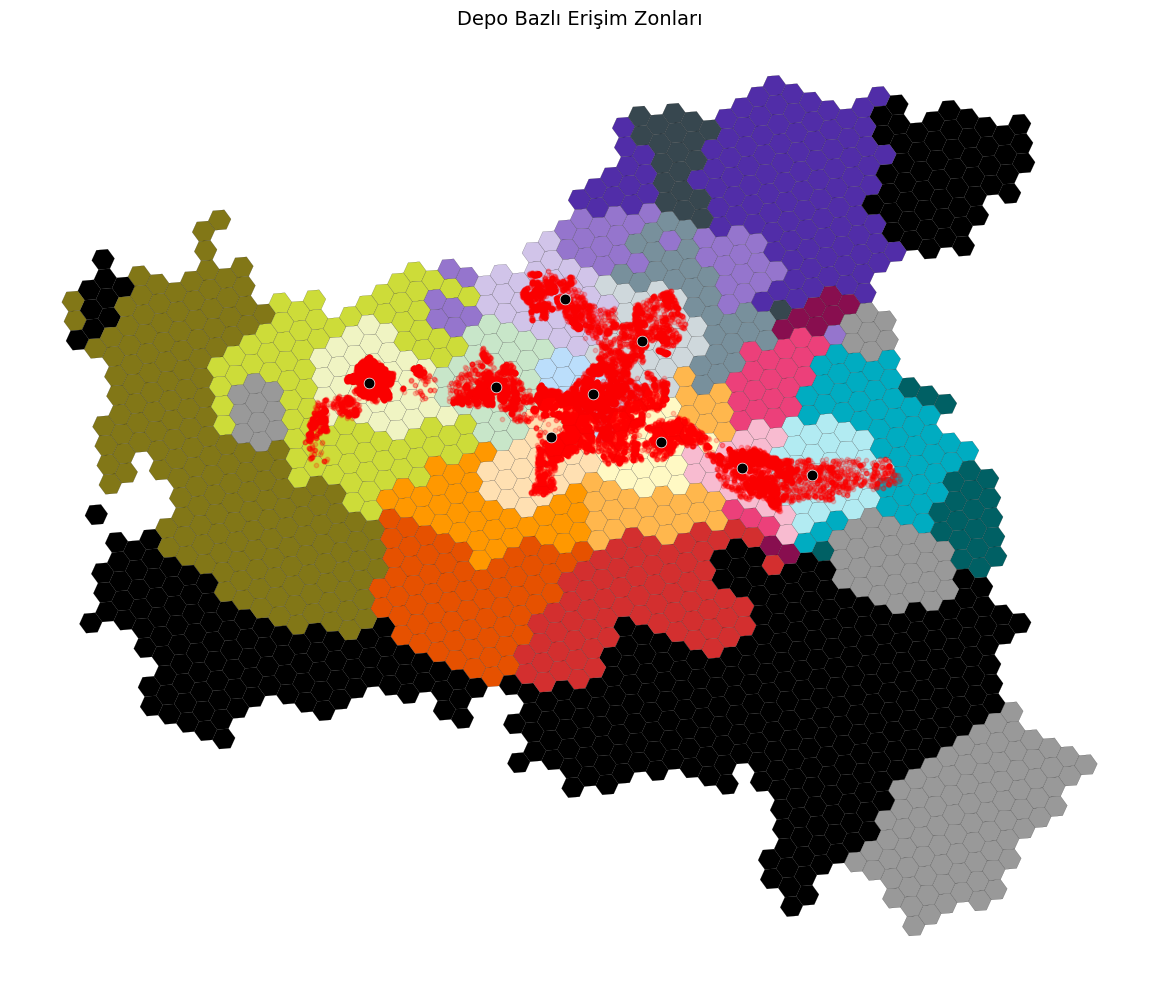

In [ ]:
#DENEME
depo_paleti = {
    "wh_1": {
        "0-5 dk": "#c8e6c9",     
        "5-10 dk": "#66bb6a",    
        "10-20 dk": "#1b5e20",   
        "20+ dk": "#000000"      
    },
    "wh_2": {
        "0-5 dk": "#fff9c4",     
        "5-10 dk": "#ffb74d",    
        "10-20 dk": "#d32f2f",   
        "20+ dk": "#000000"      
    },
    "wh_3": {
        "0-5 dk": "#bbdefb",     
        "5-10 dk": "#64b5f6",    
        "10-20 dk": "#0d47a1",   
        "20+ dk": "#000000"      
    },
    "wh_4": {
        "0-5 dk": "#f8bbd0",     
        "5-10 dk": "#ec407a",    
        "10-20 dk": "#880e4f",   
        "20+ dk": "#000000"      
    },
    "wh_5": {
        "0-5 dk": "#d1c4e9",     
        "5-10 dk": "#9575cd",    
        "10-20 dk": "#512da8",   
        "20+ dk": "#000000"      
    },
    "wh_6": {
        "0-5 dk": "#ffe0b2",     
        "5-10 dk": "#ff9800",    
        "10-20 dk": "#e65100",   
        "20+ dk": "#000000"      
    },
    "wh_7": {
        "0-5 dk": "#b2ebf2",     
        "5-10 dk": "#00acc1",    
        "10-20 dk": "#006064",   
        "20+ dk": "#000000"      
    },
    "wh_8": {
        "0-5 dk": "#cfd8dc",     
        "5-10 dk": "#78909c",    
        "10-20 dk": "#37474f",   
        "20+ dk": "#000000"      
    },
    "wh_9": {
        "0-5 dk": "#f0f4c3",     
        "5-10 dk": "#cddc39",    
        "10-20 dk": "#827717",   
        "20+ dk": "#000000"      
    }
}

def grid_rengi(row):
    depo = row["best_depot"]
    zon = row["erisim_zonu"]
    return depo_paleti.get(depo, {}).get(zon, "#999999")  # default daha koyu gri

grid_gdf["color"] = grid_gdf.apply(grid_rengi, axis=1)


grid_gdf["color"] = grid_gdf.apply(grid_rengi, axis=1)

import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 10))

# Gridleri çiz
grid_gdf.plot(color=grid_gdf["color"], ax=ax, edgecolor="black", linewidth=0.1)

# Depoları ekle
siparis.plot(ax=ax,color="red",markersize=10,alpha=0.2)
depo_gdf.plot(ax=ax, color="black", markersize=60, marker="o", edgecolor="white", linewidth=0.5)

plt.title("Depo Bazlı Erişim Zonları", fontsize=14)
plt.axis("off")
plt.tight_layout()
plt.show()

In [ ]:
#her deponun hizmet verdiği toplam sipariş sayısı 
depo_siparis_adedi = grid_gdf.groupby("best_depot")["sip_adedi_g"].sum()

depo_siparis_adedi.head(10)
#Bu skor, talep yoğunluğu / erişim süresi oranıdır. Yüksek skorlu gridler, “öncelikli servis alanı” olabilir.

#depo bazında toplam sipariş sayısını depo bazında toplam teslimat süresine bölersem depo bazında ortalama teslimat süresini bulurum.

best_depot
wh_1    2718.0
wh_2    2989.0
wh_3    3744.0
wh_4    2130.0
wh_5    2026.0
wh_6    3130.0
wh_7    1481.0
wh_8    2398.0
wh_9    5606.0
Name: sip_adedi_g, dtype: float64

In [ ]:
# Depo bazında sipariş adedi ve toplam süre
depo_stats = grid_gdf.groupby("best_depot").agg({
    "sip_adedi_g": "sum",
    "top_sure_g": "sum"
}).reset_index()

# Ortalama süreyi hesapla
depo_stats["ortalama_teslimat_suresi"] = depo_stats["top_sure_g"] / depo_stats["sip_adedi_g"]

print(depo_stats)


  best_depot  sip_adedi_g     top_sure_g  ortalama_teslimat_suresi
0       wh_1       2718.0   33261.100000                 12.237344
1       wh_2       2989.0   51598.433333                 17.262775
2       wh_3       3744.0   50065.450000                 13.372182
3       wh_4       2130.0   42023.233333                 19.729218
4       wh_5       2026.0   50523.566667                 24.937595
5       wh_6       3130.0   51713.816667                 16.521986
6       wh_7       1481.0   53514.650000                 36.134132
7       wh_8       2398.0   42155.700000                 17.579525
8       wh_9       5606.0  109648.083333                 19.559059


In [ ]:
# Depo bazında sipariş adedi ve toplam süre
depo_bulunan = grid_gdf.groupby("best_depot").agg({
    "sip_adedi_g": "sum",
    "top_sure_g": "sum"
}).reset_index()

# Ortalama süreyi hesapla
depo_stats["ortalama_teslimat_suresi"] = depo_stats["top_sure_g"] / depo_stats["sip_adedi_g"]

print(depo_stats)

  best_depot  sip_adedi_g     top_sure_g  ortalama_teslimat_suresi
0       wh_1       2718.0   33261.100000                 12.237344
1       wh_2       2989.0   51598.433333                 17.262775
2       wh_3       3744.0   50065.450000                 13.372182
3       wh_4       2130.0   42023.233333                 19.729218
4       wh_5       2026.0   50523.566667                 24.937595
5       wh_6       3130.0   51713.816667                 16.521986
6       wh_7       1481.0   53514.650000                 36.134132
7       wh_8       2398.0   42155.700000                 17.579525
8       wh_9       5606.0  109648.083333                 19.559059


In [ ]:
#SLA: 15/30/45 dk zonlarını üret; 15 dk içinde kalan talep yüzdesi 
# gibi KPI’ları ölç. Gerekirse cutoff dışında atamaları yasakla veya ceza ekle.

#Kalibrasyon: Yol ağından gelen ile “gerçek” teslimat sürelerini karşılaştırr 